# Introduction

The Project 2 required us to focus on the modeling of the data used in Project 1. 

### About the dataset: 
My initial dataset were retrieved from https://www.topuniversities.com/university-rankings/world-university-rankings/2021 webpage, and consisted of randomly sampled universities among top-1000. 
The project 1 used only 209 samples. However, for the task of modeling this number seemed not enought. 

Therefore, if before I randomly sampled 50 universities from 5 batches of 200 universities, now all 1000 were scrapped from the QS ranking list. Some of the universities there (especially ones ranked low) lack a lot of information, therefore were skipped by the get_data.py code. 

In this way, finally my data.csv dataset consisted of 706 samples (universities) and 16 features (statistics). This is the maximum number that can be got from QS webpage. 

### Motivation for modeling
Features are the info statistics about the certain university - its scores of different metrics, status and so on. Most of those 16 features could be a potential output variable for further prediction. However, since samples were from ranking list, feature _"Overall Score"_ seem to include all of the numeric information. Therefore, I assumed that there already was some linear dependancy between numeric variables, making them not interesting to predict. Instead, I categorized the __region of the university - The USA - 0, Europe - 1 and the rest of the World - 2 and tried to predict it.__

Therefore, my modeling was of classification type. Following notebook includes:

Model 1: Softmax Regression;

Model 2: Shallow Neural Networks - Hidden Layer Size = 

Model 3: Deep Neural Networks - Hidden Layers Num = 2, Size1 = , Size2 = 



In [1]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim
import pandas as pd
from torch.autograd import Variable
from torch.nn import functional as F
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

# Dataset Preparation

## Preprocessing

In [2]:
file = "data1.csv"
da = pd.read_csv(file)
print("Shape of the dataset:", da.shape)
da.head()

Shape of the dataset: (706, 16)


,Name,Country,QS Global World Ranking,Status,Research Output,Total Students,Academic Faculty Staff,International Students,Overall Score,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,Number of International Students,Number of International Faculty
0,Massachusetts Institute of Technology (MIT),United States,#1,Private,Very High,"11,342","3,011",91.9,100.0,100.0,100.0,100.0,99.1,100.0,"3,745",1681.0
1,Stanford University,United States,#2,Private,Very High,"16,260","4,478",63.6,98.4,100.0,100.0,100.0,98.1,99.7,"3,665",2166.0
2,Harvard University,United States,#3,Private,Very High,"23,583","4,556",69.9,97.9,100.0,100.0,98.6,99.1,85.2,"5,816",1466.0
3,California Institute of Technology (Caltech),United States,#4,Private,Very High,"2,237","1,059",88.2,97.0,97.0,82.8,100.0,99.9,100.0,692,563.0
4,University of Oxford,United Kingdom,#5,Public,Very High,"20,786","6,650",98.3,96.7,100.0,100.0,100.0,81.3,99.4,"8,259",3137.0


In [3]:
# making values as a numeric type 
da.loc[:,'Total Students'] = da['Total Students'].str.replace(',', '')
da.loc[:,'Academic Faculty Staff'] = da['Academic Faculty Staff'].str.replace(',', '')
da.loc[:,'Number of International Students'] = da['Number of International Students'].str.replace(',', '')
da.loc[:,'International Students'] = da['International Students'].str.replace(',', '')
da['Rank'] = range(1, len(da) + 1)  # rankings from 1 to length of data
da = da.drop(columns = 'Scholarships', errors = 'ignore')  # contains too many nan values
da.iloc[:,5:] = da.iloc[:,5:].apply(pd.to_numeric)

In [4]:
# marking three types of regions
da = da.dropna(subset = ['Country'])
europe = ['United Kingdom', 'Austria','Belarus','Belgium', 'Czech Republic', 'Denmark', 'Finland' 'France', 'Germany','Greece', 'Israel', 'Ireland', 'Italy','Lithuania', 'Hungary' , 'Netherlands', 'Norway', 'Poland', 'Portugal' 'Russia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Turkey']
da.loc[da['Country'] == ('United States'), 'Region'] = 0
da.loc[da['Country'].isin(europe), 'Region'] = 1
da.loc[(da['Country']!= 'United States') & (~da['Country'].isin(europe)), 'Region'] = 2
da.head()

,Name,Country,QS Global World Ranking,Status,Research Output,Total Students,Academic Faculty Staff,International Students,Overall Score,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,Number of International Students,Number of International Faculty,Rank,Region
0,Massachusetts Institute of Technology (MIT),United States,#1,Private,Very High,11342,3011,91.9,100.0,100.0,100.0,100.0,99.1,100.0,3745,1681.0,1,0.0
1,Stanford University,United States,#2,Private,Very High,16260,4478,63.6,98.4,100.0,100.0,100.0,98.1,99.7,3665,2166.0,2,0.0
2,Harvard University,United States,#3,Private,Very High,23583,4556,69.9,97.9,100.0,100.0,98.6,99.1,85.2,5816,1466.0,3,0.0
3,California Institute of Technology (Caltech),United States,#4,Private,Very High,2237,1059,88.2,97.0,97.0,82.8,100.0,99.9,100.0,692,563.0,4,0.0
4,University of Oxford,United Kingdom,#5,Public,Very High,20786,6650,98.3,96.7,100.0,100.0,100.0,81.3,99.4,8259,3137.0,5,1.0


In [5]:
# turning categorical variables into integers
da.loc[da['Status'] == ('Private'), 'Status'] = 0
da.loc[da['Status'] == ('Public'), 'Status'] = 1
da.loc[da['Research Output'] == ('Low'), 'Research Output'] = 0
da.loc[da['Research Output'] == ('Medium'), 'Research Output'] = 1
da.loc[da['Research Output'] == ('High'), 'Research Output'] = 2
da.loc[da['Research Output'] == ('Very High'), 'Research Output'] = 3
da.head()

,Name,Country,QS Global World Ranking,Status,Research Output,Total Students,Academic Faculty Staff,International Students,Overall Score,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,Number of International Students,Number of International Faculty,Rank,Region
0,Massachusetts Institute of Technology (MIT),United States,#1,0,3,11342,3011,91.9,100.0,100.0,100.0,100.0,99.1,100.0,3745,1681.0,1,0.0
1,Stanford University,United States,#2,0,3,16260,4478,63.6,98.4,100.0,100.0,100.0,98.1,99.7,3665,2166.0,2,0.0
2,Harvard University,United States,#3,0,3,23583,4556,69.9,97.9,100.0,100.0,98.6,99.1,85.2,5816,1466.0,3,0.0
3,California Institute of Technology (Caltech),United States,#4,0,3,2237,1059,88.2,97.0,97.0,82.8,100.0,99.9,100.0,692,563.0,4,0.0
4,University of Oxford,United Kingdom,#5,1,3,20786,6650,98.3,96.7,100.0,100.0,100.0,81.3,99.4,8259,3137.0,5,1.0


In [6]:
# dropping unnecessary features
da = da.drop(columns = ['Country','Name','QS Global World Ranking'], errors = 'ignore')
# dropping samples with a 'NaN' feature 
da = da.dropna()
da.head()

,Status,Research Output,Total Students,Academic Faculty Staff,International Students,Overall Score,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,Number of International Students,Number of International Faculty,Rank,Region
0,0,3,11342,3011,91.9,100.0,100.0,100.0,100.0,99.1,100.0,3745,1681.0,1,0.0
1,0,3,16260,4478,63.6,98.4,100.0,100.0,100.0,98.1,99.7,3665,2166.0,2,0.0
2,0,3,23583,4556,69.9,97.9,100.0,100.0,98.6,99.1,85.2,5816,1466.0,3,0.0
3,0,3,2237,1059,88.2,97.0,97.0,82.8,100.0,99.9,100.0,692,563.0,4,0.0
4,1,3,20786,6650,98.3,96.7,100.0,100.0,100.0,81.3,99.4,8259,3137.0,5,1.0


In [7]:
# standardizing feature values
da.iloc[:,2:13] = (da.iloc[:,2:13] - da.iloc[:,2:13].mean()) / da.iloc[:,2:13].std()
# normalizing feature 'rank'
da.iloc[:,-2] = (da.iloc[:,-2] - da.iloc[:,-2].min()) / (da.iloc[:,-2].max() - da.iloc[:,-2].min())
da

,Status,Research Output,Total Students,Academic Faculty Staff,International Students,Overall Score,Academic Reputation,Employer Reputation,Faculty Student,Citations per Faculty,International Faculty,Number of International Students,Number of International Faculty,Rank,Region
0,0,3,-0.895687,0.204519,1.204762,2.364348,1.720728,1.703631,1.397791,1.986089,1.120946,-0.289917,1.405374,0.000000,0.0
1,0,3,-0.534759,1.093894,0.337916,2.285894,1.720728,1.703631,1.397791,1.946730,1.112397,-0.309138,2.113493,0.002551,0.0
2,0,3,0.002670,1.141182,0.530889,2.261378,1.720728,1.703631,1.353659,1.986089,0.699215,0.207666,1.091466,0.005102,0.0
3,0,3,-1.563895,-0.978890,1.091429,2.217247,1.616891,1.135322,1.397791,2.017575,1.120946,-1.023437,-0.226950,0.007653,0.0
4,1,3,-0.202599,2.410678,1.400798,2.202537,1.720728,1.703631,1.397791,1.285509,1.103848,0.794627,3.531191,0.010204,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1,3,1.671980,2.753818,-0.345147,1.609233,1.682654,1.462430,1.063648,0.368458,0.402864,0.757627,1.875507,0.989796,0.0
389,1,3,-0.251990,0.153593,1.419177,1.565102,1.654965,0.920555,0.887119,-0.025126,1.120946,0.804718,1.907628,0.992347,2.0
390,1,3,1.123396,1.563135,-0.559561,1.555296,1.693038,1.673894,0.653849,0.640031,0.257537,0.280706,0.941082,0.994898,2.0
391,1,3,0.294465,1.094500,-0.810733,1.540586,1.720728,1.690414,1.155064,0.545571,-1.423686,-0.294722,-0.618240,0.997449,2.0


## Dataset Division intro Train, Valid and Test

In [8]:
da_copy = da.copy()
train_set = da_copy.sample(frac=0.70, random_state=0)  # train 70%
print("Train set shape:", train_set.shape)
da_copy = da_copy.drop(train_set.index)
valid_set = da_copy.sample(frac=0.50, random_state=0)  # valid 15%
print("Valid set shape:", valid_set.shape)
test_set = da_copy.drop(valid_set.index)               # test 15%
print("Test set shape:", test_set.shape)

Train set shape: (272, 15)
Valid set shape: (58, 15)
Test set shape: (58, 15)


In [9]:
# getting labels from the data samples
train_set_labels = train_set.pop('Region')
valid_set_labels = valid_set.pop('Region')
test_set_labels = test_set.pop('Region')

In [10]:
# wrapping data into tensors
train_x_tensor = Variable(torch.Tensor(list(train_set.values)))
train_y_tensor = Variable(torch.Tensor(list(train_set_labels.values)))

valid_x_tensor = Variable(torch.Tensor(list(valid_set.values)))
valid_y_tensor = Variable(torch.Tensor(list(valid_set_labels.values)))

test_x_tensor = Variable(torch.Tensor(list(test_set.values)))
test_y_tensor = Variable(torch.Tensor(list(test_set_labels.values)))

train_y_tensor = train_y_tensor.view(len(train_x_tensor), -1)
valid_y_tensor = valid_y_tensor.view(len(valid_x_tensor), -1)
test_y_tensor = test_y_tensor.view(len(test_x_tensor), -1)

In [11]:
class Data(Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label
        self.len = self.x.shape[0]

    def __getitem__(self, index):          
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

In [12]:
# making tensor datasets a torch Dataset
train_data = Data(train_x_tensor, train_y_tensor)
valid_data = Data(valid_x_tensor, valid_y_tensor)
test_data = Data(test_x_tensor, test_y_tensor)

# Model 1: Classification by Softmax Regression 

A Custom Module for Linear Regression was built:

In [13]:
class LinearReg(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearReg, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [14]:
def train_linear_with_lr(input_size, output_size, total_epochs, lr_list):
    models = []
    train_loss = [[] for i in range(len(lr_list))]
    valid_loss = [[] for i in range(len(lr_list))]
    # iterate through different learning rates
    for i, lr in enumerate(lr_list):
        # creating a model
        model = nn.Sequential(LinearReg(input_size, output_size))
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        for epoch in range(total_epochs):
            
            epoch_training_loss = 0
            epoch_validation_loss = 0
            
            # train
            for x, y in trainloader:
                optimizer.zero_grad()
                yhat = model(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                epoch_training_loss += loss.data
            
            # validation
            for x, y in validationloader:
                yhat = model(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                epoch_validation_loss += loss.data
            
            # average loss value after 1 epoch
            train_loss[i].append(epoch_training_loss/len(trainloader))
            valid_loss[i].append(epoch_validation_loss/len(validationloader))
    
        models.append(model)
    return models, train_loss, valid_loss

In [15]:
torch.manual_seed(0)  # to get same random values
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = train_data, batch_size = 4)
validationloader = DataLoader(dataset = valid_data, batch_size = 2)

input_size, output_size = 14, 3
total_epochs = 200
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

linear_models_lr, train_loss, valid_loss = train_linear_with_lr(input_size, output_size, total_epochs, learning_rates)

### When tuning the hyperparameters similar procedure was followed:
1. Plot the train and validation losses on the list of different hyperparameters.
2. Choose the one with least losses.
3. Verify its convergence
4. Use this hyperparameter to choose the next one.

Therefore some of the similar steps were omitted.
P.s: Tuning took much longer than shown in this notebook, even the values in the lists of potential hyperparameters were tuned)

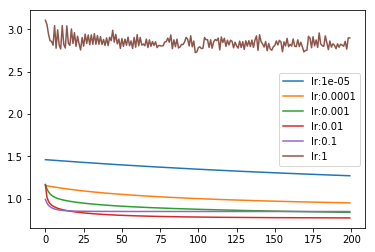

In [16]:
# Plot of the train losses for each learning rate
for i in range(len(learning_rates)):
    plt.plot(train_loss[i], label = 'lr:' + str(learning_rates[i]))
    plt.legend()
    plt.show

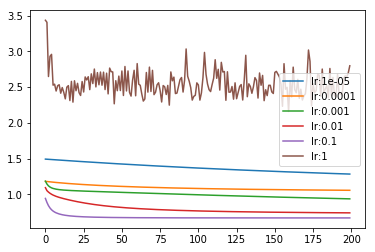

In [17]:
for i in range(len(learning_rates)):
    plt.plot(valid_loss[i], label = 'lr:' + str(learning_rates[i]))
    plt.legend()
    plt.show

According to the above graphs, __learning rate was chosen as 0.01__. Now, let's verify its convergence:

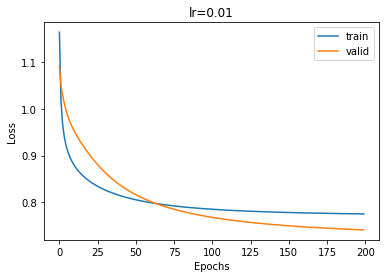

In [18]:
i=3
plt.title('lr=' + str(learning_rates[i]))
plt.plot(train_loss[i], label = 'train')
plt.show
plt.plot(valid_loss[i], label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [19]:
def test_linear(models):
    accuracies = []
    
    for i in range(len(models)):
        correct = 0
        for x, y in testloader:
            z = models[i](x.float())
            _, yhat = torch.max(z.data, 1)
            for j in range(len(yhat)):
                if yhat[j] == y[j]:
                    correct += 1
        
        accuracy = correct/len(testloader)
        accuracies.append(accuracy)
    
    return accuracies

testloader = DataLoader(dataset=test_data, batch_size = 1)
accuracies = test_linear(linear_models_lr)

for i in range(len(learning_rates)):
    print("test accuracy:", accuracies[i], ",", "lr =", learning_rates[i])

test accuracy: 0.29310344827586204 , lr = 1e-05
test accuracy: 0.5517241379310345 , lr = 0.0001
test accuracy: 0.5517241379310345 , lr = 0.001
test accuracy: 0.603448275862069 , lr = 0.01
test accuracy: 0.5517241379310345 , lr = 0.1
test accuracy: 0.46551724137931033 , lr = 1


In [20]:
def train_linear_with_bs(input_size, output_size, total_epochs, bs_list, lr):
    models = []
    train_loss = [[] for i in range(len(bs_list))]
    valid_loss = [[] for i in range(len(bs_list))]
    # iterate through different learning rates
    for i, bs in enumerate(bs_list):
        trainloader = DataLoader(dataset = train_data, batch_size = bs)
        
        # creating a model
        model = nn.Sequential(LinearReg(input_size, output_size))
        optimizer = optim.SGD(model.parameters(), lr=lr)
        
        for epoch in range(total_epochs):
            epoch_training_loss = 0
            epoch_validation_loss = 0
            
            # train
            for x, y in trainloader:
                optimizer.zero_grad()
                yhat = model(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                epoch_training_loss += loss.data
            
            # validation
            correct = 0
            for x, y in validationloader:
                yhat = model(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                epoch_validation_loss += loss.data
            
            # average loss value after 1 epoch
            train_loss[i].append(epoch_training_loss/len(trainloader))
            valid_loss[i].append(epoch_validation_loss/len(validationloader))
    
        models.append(model)
    return models, train_loss, valid_loss

In [22]:
# here we choose batch size
torch.manual_seed(0)  # to get same random values
criterion = nn.CrossEntropyLoss()
validationloader = DataLoader(dataset = valid_data, batch_size = 1)

input_size, output_size = 14, 3
total_epochs = 200
batch_sizes = [1, 2, 4, 8, 16]
lr = 0.01 # chosen from previous results
linear_models_bs, train_loss, valid_loss = train_linear_with_bs(input_size, output_size, total_epochs, batch_sizes, lr)

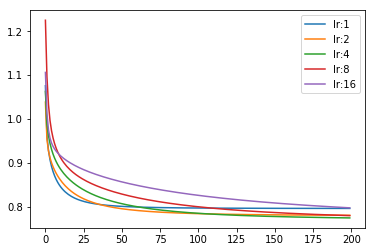

In [23]:
for i in range(len(batch_sizes)):
    plt.plot(train_loss[i], label = 'lr:' + str(batch_sizes[i]))
    plt.legend()
    plt.show

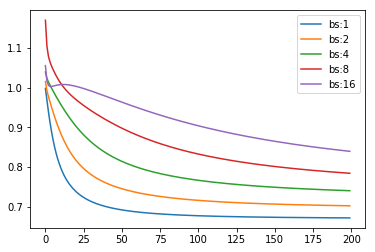

In [24]:
for i in range(len(batch_sizes)):
    plt.plot(valid_loss[i], label = 'bs:' + str(batch_sizes[i]))
    plt.legend()
    plt.show

Choose __Batch_Size = 8__, Verify its convergence:

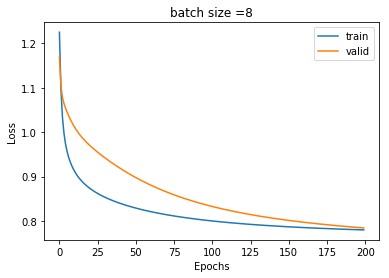

In [25]:
# Plot of the losses for each batch size
i=3
plt.title('batch size =' + str(batch_sizes[i]))
plt.plot(train_loss[i], label = 'train')
plt.show
plt.plot(valid_loss[i], label = 'valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Evaluation of the model (softmax regression with lr = 0.01, batch_size=8):

In [45]:
acc=[]
correct = 0
i=3
for x, y in testloader:
    z = linear_models_bs[i](x.float())
    _, yhat = torch.max(z.data, 1)
    for j in range(len(yhat)):
        if yhat[j] == y[j]:
            correct += 1

accuracy = correct/len(testloader)
acc.append(accuracy)
accuracy


0.603448275862069

## Model 2: Classification by Shallow NN 
### Hidden Layer Size = 5

Similarly, a custom Module for Shallow NN was built:

In [27]:
class Net(nn.Module):
    def __init__(self,D_in,H,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,D_out)

        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=torch.sigmoid(self.linear2(x))
        return x

In [28]:
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)


learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

In [29]:
def train_model_with_nn(input_size, H1, output_size, epochs, lr_list):  
    models_nn = []
    train_loss = [[] for i in range(len(lr_list))]
    valid_loss = [[] for i in range(len(lr_list))]
    
    for i, lr in enumerate(lr_list):
        model2=Net(input_size, H1, output_size)
        optimizer=torch.optim.Adam(model2.parameters(), lr=lr)
        
        for epoch in range(epochs):
            
            epoch_training_loss = 0
            epoch_validation_loss = 0

            for x,y in trainloader:
                optimizer.zero_grad()
                yhat=model2(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                epoch_training_loss += loss.data


            # perform a prediction on the validationdata  
            for x_test, y_test in validationloader:
                z = model2(x_test.float())
                _, yhat = torch.max(z.data, 1)
                epoch_validation_loss += loss.data

            train_loss[i].append(epoch_training_loss/len(trainloader))
            valid_loss[i].append(epoch_validation_loss/len(validationloader))

        models_nn.append(model2)
    return models_nn, train_loss, valid_loss


In [30]:
input_size, H1, output_size, total_epochs = 14, 10, 3, 100
models_nn, train_loss, valid_loss = train_model_with_nn(input_size, H1, output_size, total_epochs, learning_rates)

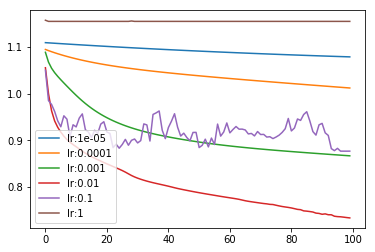

In [31]:
# Plot of the train losses for each learning rate
for i in range(len(learning_rates)):
    plt.plot(train_loss[i], label = 'lr:' + str(learning_rates[i]))
    plt.legend()
    plt.show

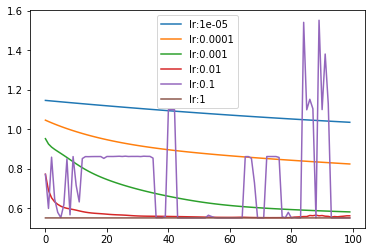

In [32]:
# Plot of the train losses for each learning rate
for i in range(len(learning_rates)):
    plt.plot(valid_loss[i], label = 'lr:' + str(learning_rates[i]))
    plt.legend()
    plt.show

Again, __lr=0.01__ is taken to be the best choice. Both of the loss seem to converge.

Choosing the size of the hidden layer:

In [33]:
def train_model_with_nn_hs(input_size, hidden_sizes, output_size, epochs, lr):  
    models_nn = []
    train_loss = [[] for i in range(len(hidden_sizes))]
    valid_loss = [[] for i in range(len(hidden_sizes))]
    
    for i, hidden_size in enumerate(hidden_sizes):
        model2 = Net(input_size, hidden_size, output_size)
        optimizer=torch.optim.Adam(model2.parameters(), lr=lr)
        
        for epoch in range(epochs):
            
            epoch_training_loss = 0
            epoch_validation_loss = 0

            for x,y in trainloader:
                optimizer.zero_grad()
                yhat=model2(x.float())
                loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
                loss.backward()
                optimizer.step()
                epoch_training_loss += loss.data

            # perform a prediction on the validationdata  
            for x_test, y_test in validationloader:
                z = model2(x_test.float())
                _, yhat = torch.max(z.data, 1)
                epoch_validation_loss += loss.data

            train_loss[i].append(epoch_training_loss/len(trainloader))
            valid_loss[i].append(epoch_validation_loss/len(validationloader))

        models_nn.append(model2)
    return models_nn, train_loss, valid_loss

In [34]:
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)
lr = 0.01
input_size, output_size, total_epochs = 14, 3, 100
hidden_sizes = [5, 10, 15, 20]
models_nn_hs, train_loss, valid_loss = train_model_with_nn_hs(input_size, hidden_sizes, output_size, total_epochs, lr)

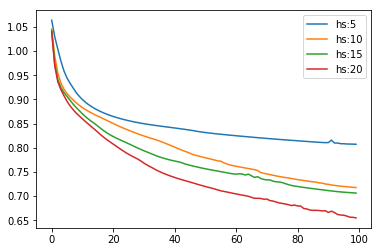

In [36]:
for i in range(len(hidden_sizes)):
    plt.plot(train_loss[i], label = 'hs:' + str(hidden_sizes[i]))
    plt.legend()
    plt.show

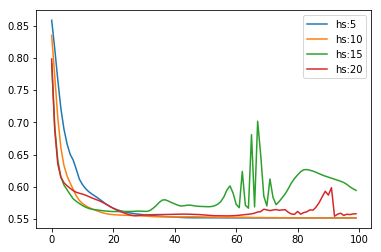

In [37]:
for i in range(len(hidden_sizes)):
    plt.plot(valid_loss[i], label = 'hs:' + str(hidden_sizes[i]))
    plt.legend()
    plt.show

### Evaluation of the model (shallow neural network with lr = 0.01, batch_size = 1, hidden size =15):

In [46]:
correct = 0
accuracy = 0
i=3
for x, y in testloader:
    z = models_nn_hs[i](x.float())
    _, yhat = torch.max(z.data, 1)
    for j in range(len(yhat)):
        if yhat[j] == y[j]:
            correct += 1

accuracy = correct/len(testloader)
acc.append(accuracy)
accuracy 



0.6724137931034483

# Model 3: Classification by Deep Neural Networks 

In [39]:
class DeepNet(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(DeepNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    
    # Prediction
    def forward(self,x):
        x = torch.relu(self.linear1(x)) 
        x = torch.relu(self.linear2(x))
        #x = torch.relu(self.linear3(x))
        x = self.linear3(x)
        return x

In [40]:
def train_model_with_dnn(input_size, H1, H2, output_size, epochs, lr):
    model = DeepNet(input_size, H1, H2, output_size)
    optimizer_dnn = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loss = []
    valid_loss = []

    for epoch in range(epochs):

        epoch_training_loss = 0
        epoch_validation_loss = 0

        for x,y in trainloader:
            optimizer_dnn.zero_grad()
            yhat=model(x.float())
            loss = criterion(yhat, y.view(len(yhat[:,0])).type(torch.LongTensor))
            loss.backward()
            optimizer_dnn.step()
            epoch_training_loss += loss.data

        # perform a prediction on the validation data  
        for x_test, y_test in validationloader:
            z = model(x_test.float())
            _, yhat = torch.max(z.data, 1)
            epoch_validation_loss += loss.data

        train_loss.append(epoch_training_loss/len(trainloader))
        valid_loss.append(epoch_validation_loss/len(validationloader))

    return model, train_loss, valid_loss

For Deep NN similar procedure of hyperparameters tuning was used. Best ones so far were: __Hidden Layers num = 2, H1 size = 10, H2 size = 10, lr = 0.001, batch_size=8__

In [41]:
criterion = nn.CrossEntropyLoss()
trainloader = DataLoader(dataset = train_data, batch_size = 8)
lr = 0.001
input_size, output_size, total_epochs = 14, 3, 200
H1, H2 = 10, 10
model, train_loss, valid_loss = train_model_with_dnn(input_size, H1, H2, output_size, total_epochs, lr)

In [47]:
correct = 0
accuracy = 0
for x, y in testloader:
    z = model(x.float())
    _, yhat = torch.max(z.data, 1)
    for j in range(len(yhat)):
        if yhat[j] == y[j]:
            correct += 1

accuracy = correct/len(testloader)
acc.append(accuracy)
accuracy 



0.7931034482758621

## Evaluation of the results
### Accuracy of the models on the test split
| Softmax Regression | Shallow NN | Deep NN |
| :- | -: | :-: |
| 0.6034483 | 0.67241379 | 0.79310344

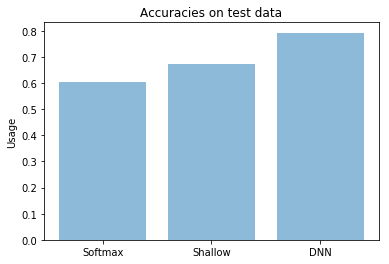

In [50]:
objects = ('Softmax', 'Shallow', 'DNN')
y_pos = np.arange(len(objects))


plt.bar(y_pos, acc, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Accuracies on test data')

plt.show()

# Conclusion

During this project the basics of pyTorch library and its application with neural networks were learned. 
Overall, the Coursera Course seem to be not the best one for me, such a short videos with assumption of previous knowledge did not taught a lot. However, this project covered the gaps that remained unclear after the course. Implementation of modules, dealing with losses, tensors and tuning hyperparameters - gave a clear sense of neural networks. 

At first my data seem to be not applicable and not appropriate for the project - not enough samples, loss and accuracies were very unstable. 

__The most interesting thing comes when the data that seemed not relatable at the beginning, achieved good testing accuracy! I found 79.3% very impressive for myself__